# Boston Housing Prices Prediction

A machine learning project at Xccelerate HK, by Tiran Ranasinghe, Curtis To, Alfred Wong

In this project we take the Boston housing prices dataset, where the target variable is the median value of owner-occupied homes in different areas in Boston, and the featrues are characteristics of the areas.

First we explore and visualize the data to look for anomalies and hopefully insights, then we do PCA and automated feature selection to generate different feature sets.

These sets of features or principal components are then fed into a gridsearch algorithm to train different classifier models. 

The gridsearch iterates lists of algorithms and hyperparameters, with a KFold cross validation each time. 

The combination of feature set, algorithm and hyperparameters with the highest R2 score is selected.


[Data source](https://raw.githubusercontent.com/scikit-learn/scikit-learn/master/sklearn/datasets/data/boston_house_prices.csv)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, ShuffleSplit
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, make_scorer
from sklearn.decomposition import PCA

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (13, 8) #deault figure size
plt.style.use('ggplot') #make plot prettier


# Load Data

In [2]:
df=pd.read_csv('https://raw.githubusercontent.com/scikit-learn/scikit-learn/master/sklearn/datasets/data/boston_house_prices.csv',skiprows=1)

# Inspect Data for Validitiy

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null int64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null int64
TAX        506 non-null int64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
MEDV       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB


| ColumnKey | Description                                                           |
|-----------|-----------------------------------------------------------------------|
| CRIM      | per capita crime rate by town                                         |
| ZN        | proportion of residential land zoned for lots over 25,000 sq.ft.      |
| INDUS     | proportion of non-retail business acres per town                      |
| CHAS      | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| NOX       | nitric oxides concentration (parts per 10 million)                    |
| RM        | average number of rooms per dwelling                                  |
| AGE       | proportion of owner-occupied units built prior to 1940                |
| DIS       | weighted distances to five Boston employment centres                  |
| RAD       | index of accessibility to radial highways                             |
| TAX       | full-value property-tax rate per \$10,000                             |
| PTRATIO   | pupil-teacher ratio by town                                           |
| B         | 1000(Bk - 0.63)^2  where Bk is the proportion of blacks by town       |
| LSTAT     | \% lower status of the population                                      |
| MEDV      | Median value of owner-occupied homes in \$1000's                      |

In [5]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

In [6]:
df.columns = ['Crime','ZoneOver25000','NonRetailArea','RiverBound','NOX','Rooms','PropBefore1940','DistJobCentre','RadialHighway','Tax','PupilTeacherRatio','PropBlck','LowerStat','MedianPrice']

In [7]:
df.describe()

,Crime,ZoneOver25000,NonRetailArea,RiverBound,NOX,Rooms,PropBefore1940,DistJobCentre,RadialHighway,Tax,PupilTeacherRatio,PropBlck,LowerStat,MedianPrice
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [8]:
df.isna().sum()

Crime                0
ZoneOver25000        0
NonRetailArea        0
RiverBound           0
NOX                  0
Rooms                0
PropBefore1940       0
DistJobCentre        0
RadialHighway        0
Tax                  0
PupilTeacherRatio    0
PropBlck             0
LowerStat            0
MedianPrice          0
dtype: int64

# EDA

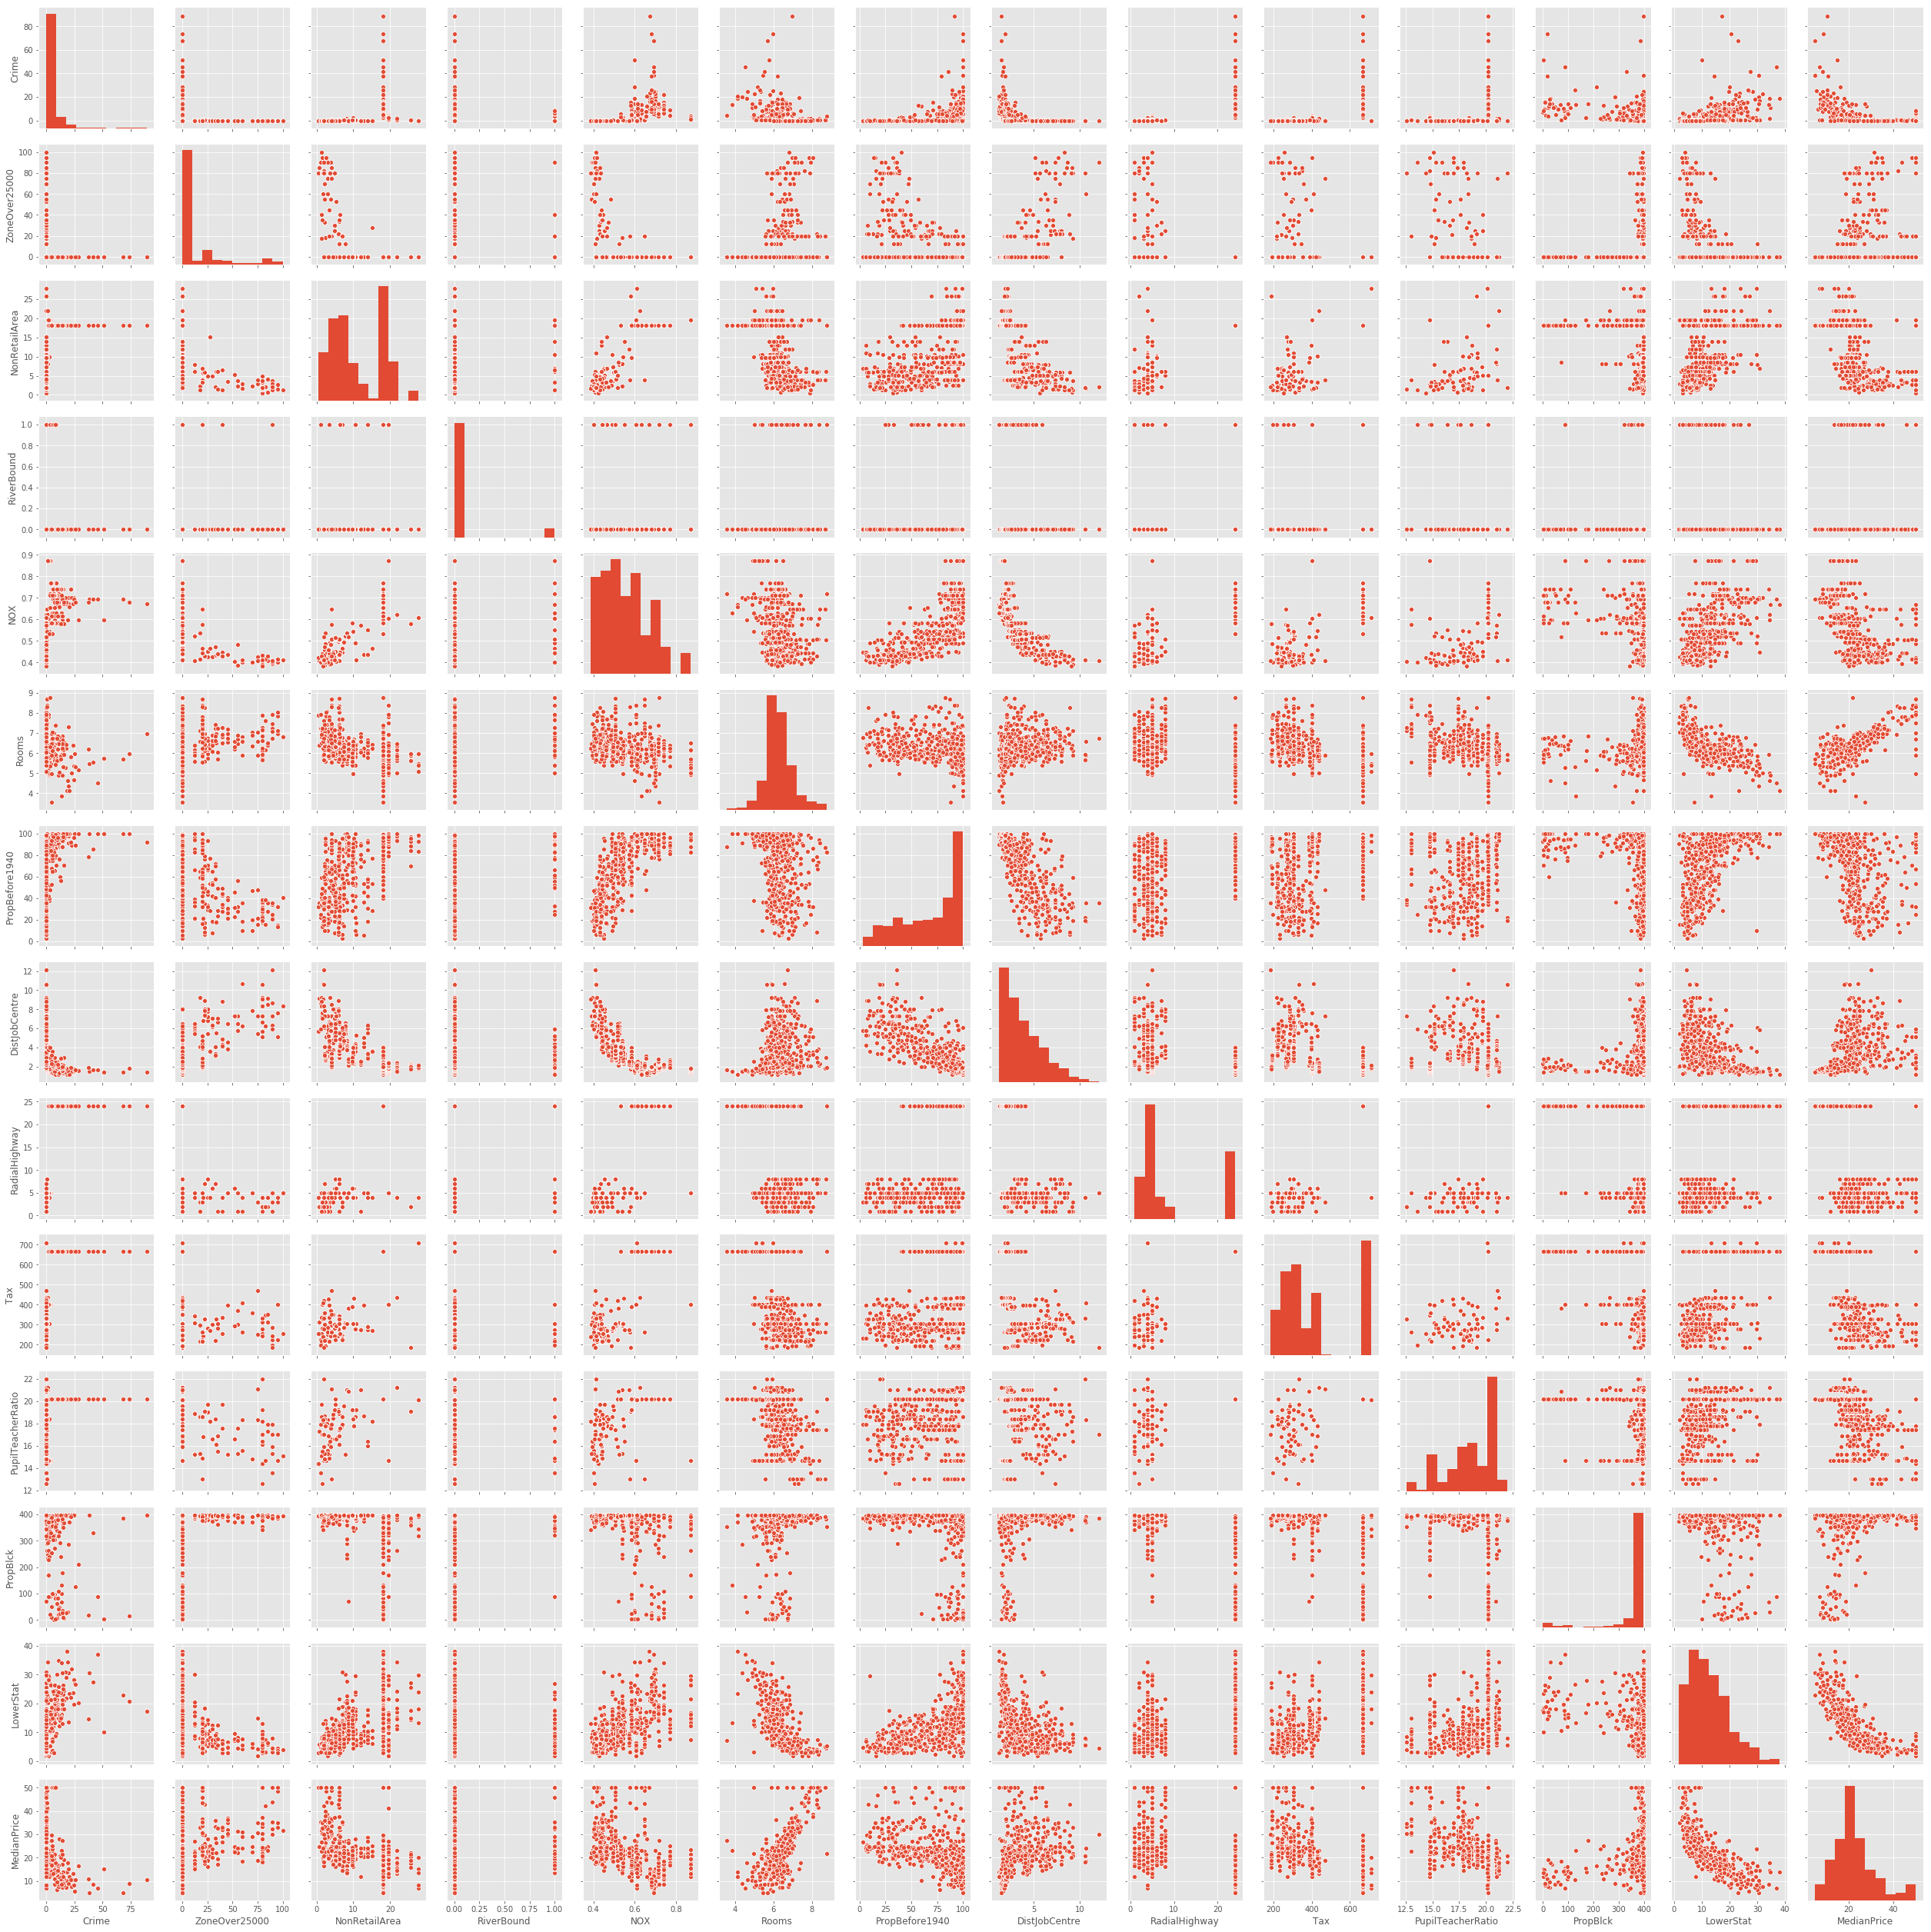

In [62]:
sns.pairplot(df)

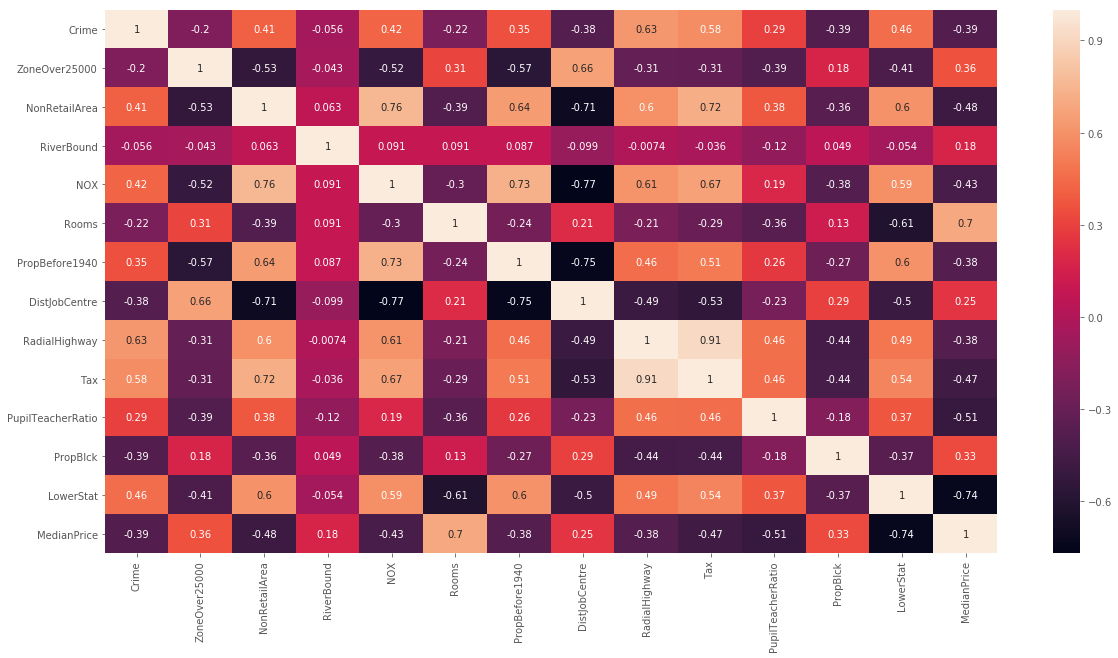

In [63]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),annot=True)

C:\Curtis\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


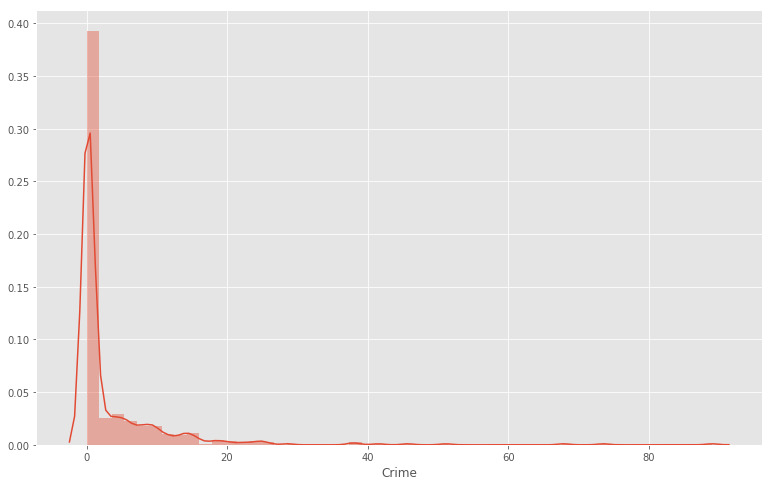

In [64]:
sns.distplot(df.Crime)

In [65]:
print((df.Crime.max(),df.Crime.min()))

(88.9762, 0.00632)


How come the crime rate is so skewed?
Usually crime rate is the number of crimes commited per 1000 people per year
The data definition says *per capita* crime rate, so we take it as crimes commited per person per year?

In that case, the lower values (min is 0.00632) kinda make sense, but the higher ones, (max is 88 and there are around 20 rows with values > 20, and 4 of them values > 50

50 crimes a year? they must be really busy

C:\Curtis\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


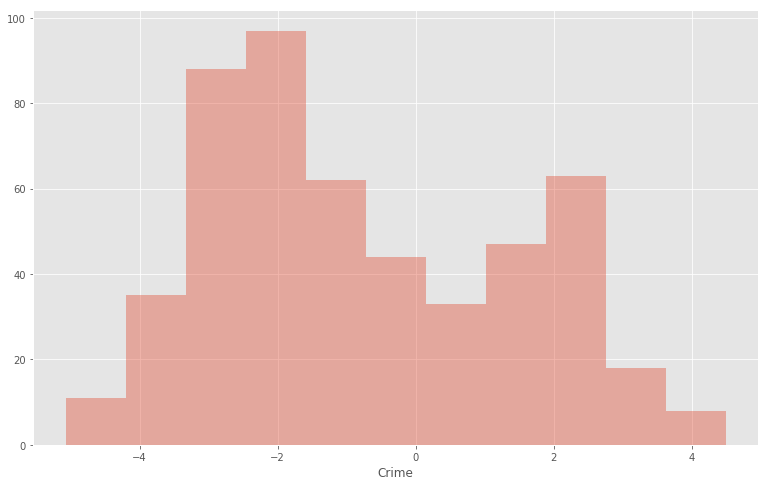

In [66]:
sns.distplot(np.log(df.Crime), kde=False)

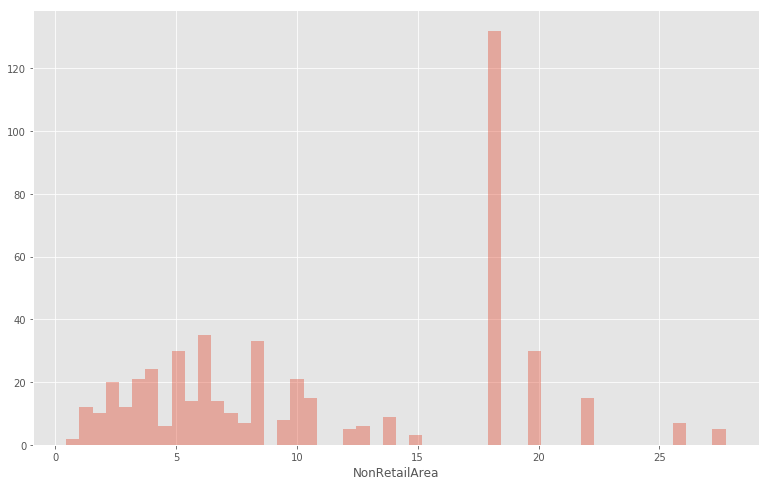

In [67]:
sns.distplot(df.NonRetailArea, kde=False, bins=50)

In [68]:
df.NonRetailArea.sort_values(ascending=False)

491    27.74
492    27.74
488    27.74
489    27.74
490    27.74
126    25.65
125    25.65
124    25.65
122    25.65
121    25.65
120    25.65
123    25.65
132    21.89
130    21.89
133    21.89
134    21.89
135    21.89
136    21.89
137    21.89
138    21.89
131    21.89
139    21.89
140    21.89
141    21.89
127    21.89
128    21.89
129    21.89
146    19.58
151    19.58
144    19.58
       ...  
306     2.18
305     2.18
304     2.18
3       2.18
4       2.18
5       2.18
202     2.03
201     2.03
353     2.02
348     2.01
355     1.91
354     1.91
342     1.89
286     1.76
351     1.69
352     1.69
197     1.52
341     1.52
196     1.52
198     1.52
200     1.47
199     1.47
64      1.38
57      1.32
349     1.25
350     1.25
55      1.22
283     1.21
56      0.74
195     0.46
Name: NonRetailArea, Length: 506, dtype: float64

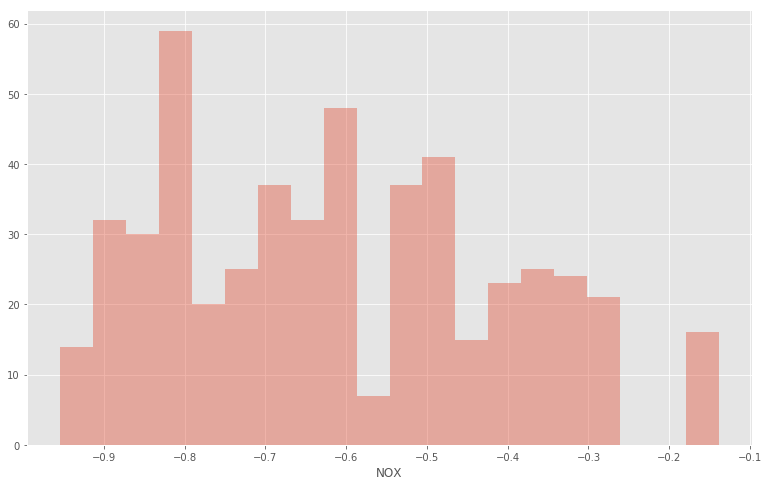

In [69]:
sns.distplot(np.log(df.NOX), kde=False,  bins=20)

C:\Curtis\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


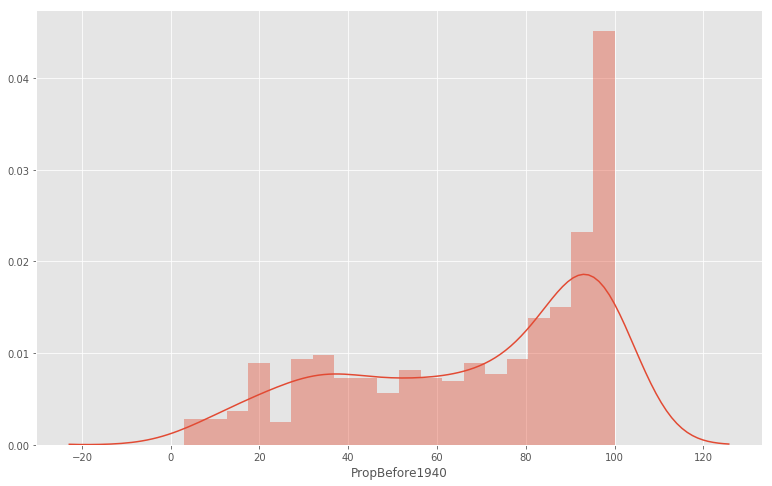

In [70]:
sns.distplot(df.PropBefore1940, bins=20)

In [71]:
df.PropBefore1940.sort_values(ascending=False)

420    100.0
406    100.0
383    100.0
158    100.0
386    100.0
151    100.0
258    100.0
259    100.0
398    100.0
400    100.0
401    100.0
402    100.0
405    100.0
443    100.0
442    100.0
407    100.0
382    100.0
437    100.0
409    100.0
410    100.0
411    100.0
412    100.0
146    100.0
413    100.0
145    100.0
414    100.0
143    100.0
415    100.0
142    100.0
141    100.0
       ...  
352     18.5
293     18.4
302     18.4
65      17.8
303     17.7
249     17.5
71      17.5
329     17.2
228     17.0
271     16.3
40      15.8
202     15.7
199     15.3
325     14.7
200     13.9
250     13.0
299     10.0
193      9.9
214      9.8
251      8.9
253      8.4
243      7.8
72       7.8
252      6.8
42       6.6
70       6.6
43       6.5
73       6.2
74       6.0
41       2.9
Name: PropBefore1940, Length: 506, dtype: float64

C:\Curtis\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


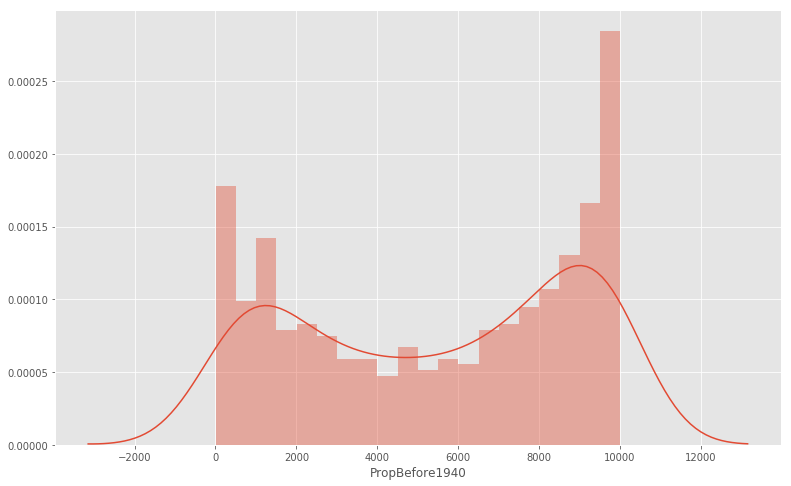

In [72]:
sns.distplot((df.PropBefore1940)**2, bins=20)

C:\Curtis\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


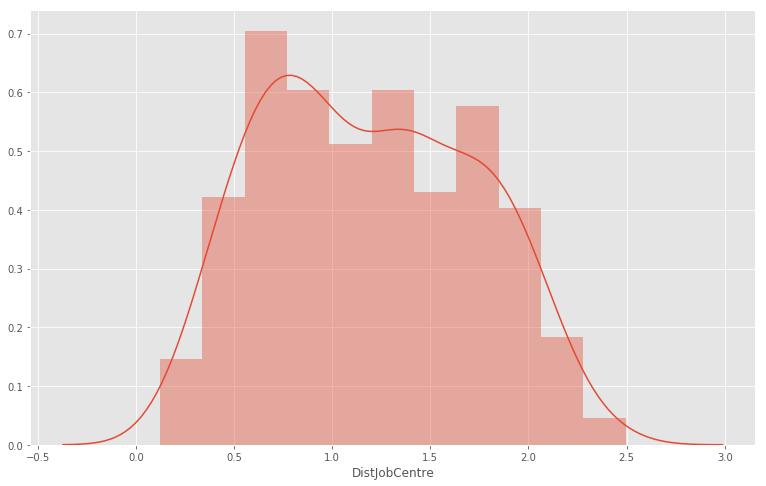

In [73]:
sns.distplot(np.log(df.DistJobCentre))

In [74]:
df.RadialHighway.sort_values(ascending=False)

371    24
410    24
408    24
407    24
406    24
405    24
404    24
403    24
402    24
401    24
400    24
399    24
398    24
397    24
396    24
395    24
394    24
409    24
411    24
429    24
412    24
427    24
426    24
425    24
424    24
423    24
422    24
421    24
420    24
419    24
       ..
2       2
88      2
122     2
196     2
121     2
120     2
56      2
202     2
201     2
198     2
505     1
193     1
332     1
503     1
502     1
501     1
350     1
349     1
342     1
341     1
331     1
194     1
286     1
285     1
284     1
283     1
255     1
254     1
504     1
0       1
Name: RadialHighway, Length: 506, dtype: int64

Looks like they set a cap at 24 for RadialHighway. 

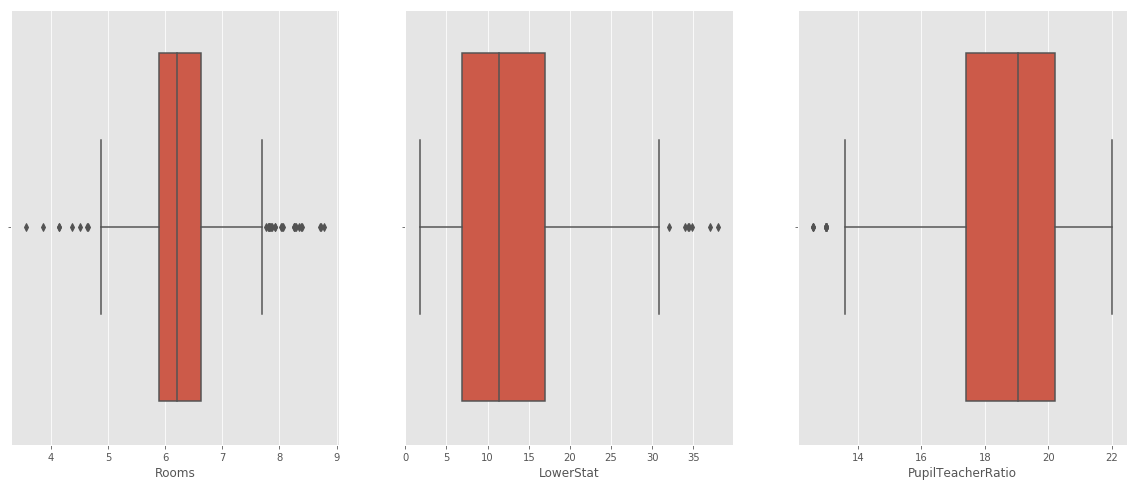

In [75]:
fig, ax = plt.subplots(1,3,figsize=(20,8))

sns.boxplot(df.Rooms,ax=ax[0])
sns.boxplot(df.LowerStat, ax=ax[1])
sns.boxplot(df.PupilTeacherRatio,ax=ax[2])

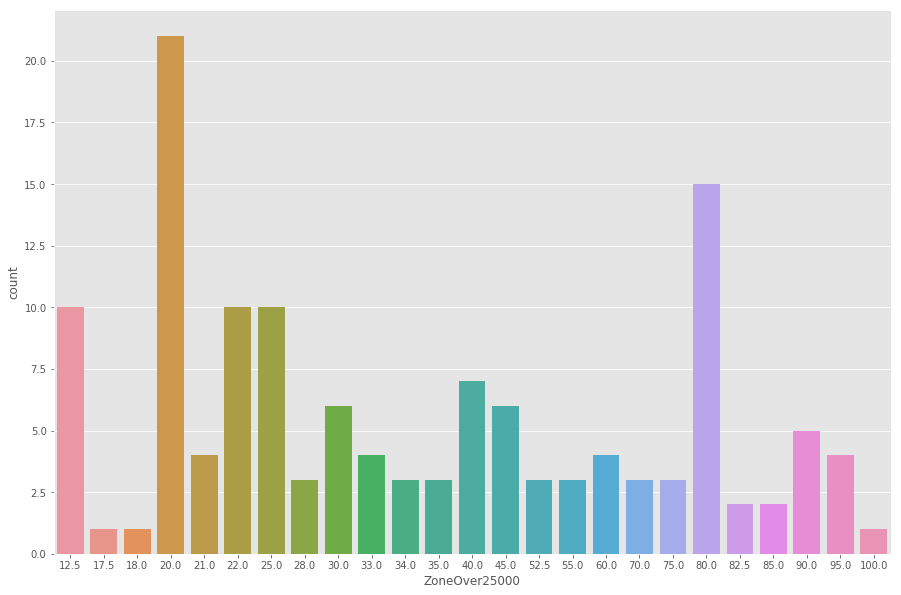

In [76]:
plt.figure(figsize=(15,10))
sns.countplot(df[df.ZoneOver25000 > 0].ZoneOver25000)

C:\Curtis\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


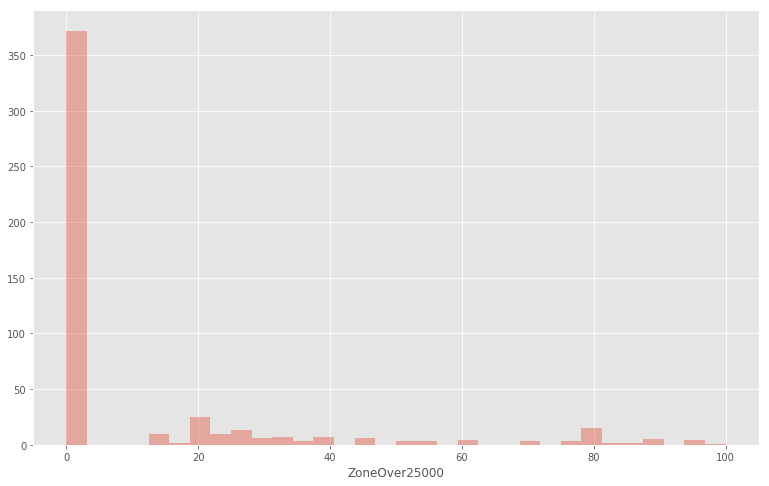

In [77]:
sns.distplot(df.ZoneOver25000, kde=False)

C:\Curtis\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


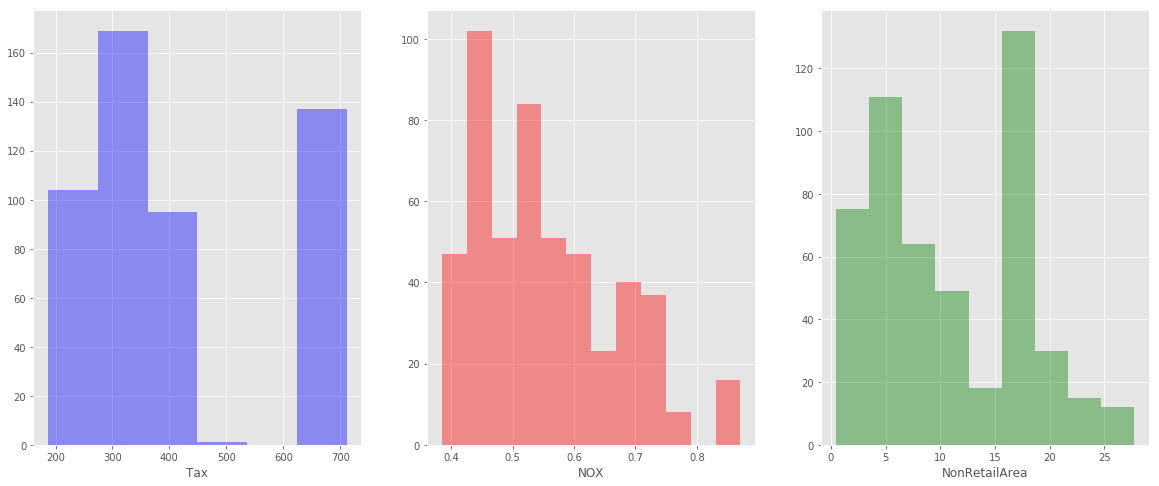

In [78]:
fig,ax= plt.subplots(1,3,figsize=(20,8))
sns.distplot(df.Tax,ax=ax[0],kde=False ,color='blue')
sns.distplot(df.NOX,ax=ax[1],kde=False ,color='red')
sns.distplot(df.NonRetailArea,ax=ax[2],kde=False ,color='green')

C:\Curtis\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


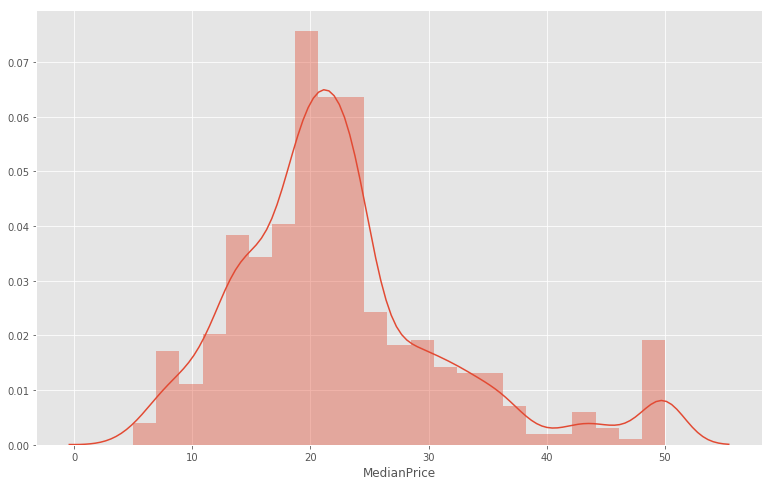

In [79]:
sns.distplot(df.MedianPrice)

# Modelling

## Feature Engineering

#### Option 0: Raw

#### Option 1: Do log transform because EDA tells us the data is skewed

In [9]:
# Transformed variables
df_raw = df.copy()

df['Crime_log'] = np.log(df.Crime)
df['PropBefore1940_squared'] = df.PropBefore1940**2
df['NOX_log'] = np.log(df.NOX)
df['DistJobCentre_log'] = np.log(df.DistJobCentre)
df['HaveBigZones'] = df.ZoneOver25000 > 0

df = df.drop([
    'Crime_log', 'PropBefore1940_squared', 
    'NOX_log', 'DistJobCentre_log', 'HaveBigZones'
], axis=1)

#### Option 2: Split Crime into adatptive bins of quartiles

In [81]:
## Updating DF with dummies to account for features with adistribution

quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
df_dummied = df_raw.copy()

df_dummied['Crime_Quantiles'] = pd.qcut(
    df_dummied.Crime, q=[0, .25, .5, .75, 1], labels=quantile_labels
)
df_dummied = pd.get_dummies(
    data=df_dummied, prefix='CQ', columns=['Crime_Quantiles'],sparse=True
)
df_dummied = df_dummied.drop(['MedianPrice', 'Crime'], axis=1)


#### Option 3: Keeps all the original features, add all 2nd degree interaction 

In [82]:
# keeps all the original features, add all 2nd degree interaction 
# terms including x1*x2 and x1 squared.
poly = PolynomialFeatures(
    degree=2, interaction_only=False, include_bias=False
)
poly_features = poly.fit_transform(df[features])
poly.n_output_features_
# we have 14 original columns, the output here is 
# nCr(14, 2) + 14. +14 because there are the original
# terms in there.

27

## Feature selection and dimension reduction

In [10]:
target = 'MedianPrice'
features = list(df.columns)
features.remove(target)

features_raw = list(df_raw.columns)
features_raw.remove(target)

#### PCA

In [11]:
def do_PCA(n, features_data, random_state=None, print_result=False):
    '''
    Takes an array of feature_data and performs a PCA.
    
    Parameters:
    ----------
    n: int
        number of components to keep in the PCA. Unlike the standard PCA
        object, cannont take None or decimals.
        
    features_data: np.array
        numpy array of feature data. shape has to match the row number 
        of target data.
        
    random_state: int, optional
        random seed for both the RandomForestRegressor and the cross
        validation splits
        
    print_result: bool, defaults to False
        if True, print the details of the PCA results
    
    Returns:
    ----------
    PCA object
        object containing the info of the transformation.
    
    DataFrame object
        data after the PCA transformation, with nice column names
    '''
      
    # normalize
    features_data_normed = StandardScaler().fit_transform(features_data)
        
    # PCA
    pc_list = ["PC"+str(i) for i in range(1,n+1)]
    pca = PCA(n, random_state=random_state)
    x_pca = pca.fit_transform(features_data_normed)
    df_pca = pd.DataFrame(x_pca, columns=pc_list)
    
    # plotting explained variance
    df_explained_variance = pd.DataFrame({
        "pc": pc_list, 
        "explained_variance": pca.explained_variance_ratio_
    })

    print("Number of PCs:", n)
    print("Total explained variance:", sum(pca.explained_variance_ratio_))

    # option to print results
    if print_result:
        # checking results
        print("-"*30)
        print(df_pca.head())
        barplot = sns.barplot(
            x="pc", 
            y="explained_variance",
            data=df_explained_variance
        )
        plt.show()
        plt.clf()
    
    print ("PCA completed")
    return pca, df_pca

## Define models

Objective: Find the best model

For each of the following model.

1. Linear Regression (No hyperparameters)
2. Random Forest Regressor (run GirdSearch_CV to find the best hyperparameters)
3. Elastic Net Regression (run Elastic Net_CV to find the best hyperparameters)

For sake of this exercise the best metric is defined by highest R2.

=> Metric = R2



In [12]:
def try_models(
    features_data, target_data, rf_params, num_folds=5, random_state=None,
    verbose=False, title=None
):
    '''
    Takes an array of feature data and tries a GridSearchCV on a 
    RandomForestRegressor with the parameters inputted, and then do
    a linear regression on the same set of features. 
    
    Returns both regressor objects and prints the results.
    
    R2_score is used for all scoring.
    
    Parameters:
    ----------
    features_data: np.array
        numpy array of feature data. shape has to match the row number 
        of target data.
    
    target_data: np.array like object
        array like object, can be series or df. must be single column.
        row number must match that of features.
        
    rf_params: dict
        dictionary of parameters to put into the rfr. values can be 
        single parameter values or lists of values
                
    num_folds: int, defaults to 5
        Number of folds to do in the cross validation
        
    random_state: int, optional
        random seed for both the RandomForestRegressor and the cross
        validation splits
        
    verbose: bool, defaults to False
        If True, print detailed results
        
    title: string, optional
        Name of the trial
    
    Returns:
    ----------
    GridSearchCV object
        returned from the grid search. Refitted and can directly be used
        to predict.
        
    LinearRegression object
        returned from the kfoldCV. Refitted on the whole dataset and can
        be used to predict.           
    '''
    # R2_score is a metric in sklearn. To turn it into a scorer function 
    # we have to  this.
    r2_scorer = make_scorer(r2_score, greater_is_better=True)
    
    # GridSearchCV doesnt have any control over splitting and it doesn't 
    # randomize. We have to put a random splitting into it
    kf = KFold(n_splits=num_folds, random_state=random_state, shuffle=True)
    
    # make sure it is in array format to avoid indexing error with 
    # dataframes and series
    features_data = np.array(features_data)
    
    if title:
        print('\n\n*************************************')
        print(f'{title}\n*************************************\n')
    
    # Random forest regressor
    rfr = RandomForestRegressor(n_jobs=-1, random_state=random_state)
    rf_params = rf_params
    grided_rfr = do_gscv(
        regressor=rfr, x=features_data, y=target_data, params=rf_params,
        scorer=r2_scorer, splitter=kf, model_name='Random forest regressor',
        verbose=False)
    
    # Linear regression
    lm = LinearRegression()
    lm = do_kfold(
        regressor=lm, x=features_data, y=target_data, 
        kf=kf, model_name='Linear regression', verbose=False
    )
    lm.fit(features_data, target_data)  # refit on the full set
    
    # Elastic Net CV
    encv = ElasticNetCV(
        # sklearn documentation suggests using more values close to 1 (lasso)
        # and fewer to 0
        l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
        cv=kf,
        verbose=verbose,
        random_state=random_state,
        selection='random'
    )
    encv = do_kfold(
        regressor=encv, x=features_data, y=target_data, 
        kf=kf, model_name='Elastic net CV', verbose=False
    )
    encv.fit(features_data, target_data) # refit on the full set
    return grided_rfr, lm, encv

def do_kfold(regressor, x, y, kf, model_name='', verbose=False):
    '''
    Does a KFoldCV on a regressor, prints the results, and 
    returns the regressor itself
    '''
    score_list = []
    for train_index, test_index in kf.split(x):            
        x_train = x[train_index]
        y_train = y[train_index]
        x_test =  x[test_index]
        y_test =  y[test_index]

        regressor.fit(x_train, y_train)
        pred = regressor.predict(x_test)
        train_r2 = regressor.score(x_train, y_train)
        test_r2 = r2_score(y_test, pred)
                
        score_list.append({'train_r2': train_r2, 'test_r2': test_r2})
    
    score_df = pd.DataFrame(score_list, columns=['train_r2', 'test_r2'])
    score_df.index.name = 'fold'
    print('\n')
    print(model_name)
    print(f'R2 score:\n{score_df.mean()[1]}')
    if verbose:
        print(f'Detailed results: \n{score_df}')
        
    return regressor
    
def do_gscv(regressor, x, y, params, scorer, splitter, model_name='', verbose=False):
    '''
    Does a GridSearchCV on a regressor and prints the results.
    Returns the regressor itself refitted
    '''
    regressor = GridSearchCV(
        estimator=regressor, param_grid=params,
        scoring=scorer,
        cv=splitter, refit=True
    )
    regressor.fit(x, y)
    
    print(f"GridSearchCV on {model_name}")
    print("Hyperparameters searched: ")
    print(params)
    print(f"Best parameters: \n{regressor.best_params_}")
    print(f"R2 score of this model: {regressor.best_score_}")
    if verbose:
        print(f'Detailed results: \n{regressor.cv_results_}')
        
    return regressor

In [13]:
pca_5, pc_5_data = do_PCA(5, df[features], 42)
pca_next_5, pc_next_5_data = do_PCA(10, df[features], 42)
pc_next_5_data = pc_next_5_data.iloc[:,5:]

Number of PCs: 5
Total explained variance: 0.807317820505
PCA completed
Number of PCs: 10
Total explained variance: 0.967782569016
PCA completed


In [19]:


to_try_list = [
    df[features], pc_5_data, pc_next_5_data
    
]
titles_list = [
    'plain_all_transformed_features', 'pc_5_data', 
    'pc_next_5_data'
]

rf_params = {
    'criterion': ['mse'],
    'max_depth': [6, 12],
    'max_leaf_nodes': [25, 50, 100, 200]
}

for features_data, title in zip(to_try_list, titles_list):
    try_models(
        features_data=features_data,
        target_data=df[target],
        rf_params=rf_params,
        num_folds=5,
        random_state=32,
        verbose=False,
        title=title
    )



*************************************
plain_all_transformed_features
*************************************

GridSearchCV on Random forest regressor
Hyperparameters searched: 
{'criterion': ['mse'], 'max_depth': [6, 12], 'max_leaf_nodes': [25, 50, 100, 200]}
Best parameters: 
{'criterion': 'mse', 'max_depth': 12, 'max_leaf_nodes': 100}
R2 score of this model: 0.8659124366904263


Linear regression
R2 score:
0.712007143532114


Elastic net CV
R2 score:
0.6810422387601955


*************************************
pc_5_data
*************************************

GridSearchCV on Random forest regressor
Hyperparameters searched: 
{'criterion': ['mse'], 'max_depth': [6, 12], 'max_leaf_nodes': [25, 50, 100, 200]}
Best parameters: 
{'criterion': 'mse', 'max_depth': 12, 'max_leaf_nodes': 200}
R2 score of this model: 0.6960985646192529


Linear regression
R2 score:
0.6867281768782993


Elastic net CV
R2 score:
0.6868478572351381


*************************************
pc_next_5_data
*************

In [86]:
# We have 3 operations in changing / selecting features, and ways to 
# to combine them -- PolynomialFeatures, PCA, SelectKBest
# I am trying the following:
'''
Original >> PCA and keep top 5

Original >> generate polynomials >> PCA keep top 5
Original >> generate polynomials >> PCA keep top 20

Original >> SKB top 5

Original >> generate polynomials >> SKB top 5
Original >> generate polynomials >> SKB top 20

Original >> PCA and keep all >> SKB top 5

Original >> PCA and keep top 5 >> generate polynomials

Or maybe top 5 can be substituted by the PCA explained variance longest
elbow distance.
'''
# I am being verbose here and spell out all the steps manually because
# we have to keep the PCA objects anyway, so that in production we can 
# use them to convert new data points


pca_5, pc_5_data = do_PCA(5, df[features], 42)
poly_pca_5, poly_pc_5_data = do_PCA(5, poly_features, 42)
poly_pca_20, poly_pc_20_data = do_PCA(20, poly_features, 42)
skb_5_data = (SelectKBest(f_regression, k=5)
              .fit_transform(df[features], df[target]))
poly_skb_5_data = (SelectKBest(f_regression, k=5)
                   .fit_transform(poly_features, df[target]))
poly_skb_20_data = (SelectKBest(f_regression, k=20)
                    .fit_transform(poly_features, df[target]))

pca_all, pc_all_data = do_PCA(13, df[features], 42)
pc_skb_5_data = (SelectKBest(f_regression, k=5)
                   .fit_transform(pc_all_data, df[target]))
pc_5_poly_data = poly.fit_transform(pc_5_data)


Number of PCs: 5
Total explained variance: 0.8073178205045921
PCA completed
Number of PCs: 5
Total explained variance: 0.9576620734946
PCA completed
Number of PCs: 20
Total explained variance: 0.9998575971205536
PCA completed
Number of PCs: 13
Total explained variance: 1.0000000000000002
PCA completed


In [88]:
to_try_list = [
    df_raw[features_raw], df[features], 
    df_dummied, pc_5_data, 
    poly_pc_5_data, poly_pc_20_data, skb_5_data, 
    poly_skb_5_data, poly_skb_20_data, pc_skb_5_data, 
    pc_5_poly_data
]
titles_list = [
    'plain_all_raw_features', 'plain_all_raw_features_crime_rate_binned',
    'plain_all_transformed_features', 'pc_5_data', 
    'poly_pc_5_data', 'poly_pc_20_data', 'skb_5_data', 
    'poly_skb_5_data', 'poly_skb_20_data', 'pc_skb_5_data', 
    'pc_5_poly_data'
]

rf_params = {
    'criterion': ['mse', 'mae'],
    'max_depth': [6, 12],
    'max_leaf_nodes': [25, 50, 100, 200]
}

for features_data, title in zip(to_try_list, titles_list):
    try_models(
        features_data=features_data,
        target_data=df[target],
        rf_params=rf_params,
        num_folds=5,
        random_state=32,
        verbose=False,
        title=title
    )



*************************************
plain_all_raw_features
*************************************

GridSearchCV on Random forest regressor
Hyperparameters searched: 
{'criterion': ['mse', 'mae'], 'max_depth': [6, 12], 'max_leaf_nodes': [25, 50, 100, 200]}
Best parameters: 
{'criterion': 'mse', 'max_depth': 12, 'max_leaf_nodes': 100}
R2 score of this model: 0.8659124366904263


Linear regression
R2 score:
0.7120071435321157


Elastic net CV
R2 score:
0.6810422387601955


*************************************
plain_all_raw_features_crime_rate_binned
*************************************

GridSearchCV on Random forest regressor
Hyperparameters searched: 
{'criterion': ['mse', 'mae'], 'max_depth': [6, 12], 'max_leaf_nodes': [25, 50, 100, 200]}
Best parameters: 
{'criterion': 'mse', 'max_depth': 12, 'max_leaf_nodes': 100}
R2 score of this model: 0.8659124366904263


Linear regression
R2 score:
0.7120071435321157


Elastic net CV
R2 score:
0.6810422387601955


****************************

# Conclusion:

Highest R2 is around 0.866
Using: plain_all_raw_features, Random Forest Regressor

Retrieving the RF object for a closer look on its best hyperparameters and feature importance



*************************************
plain_all_raw_features
*************************************

GridSearchCV on Random forest regressor
Hyperparameters searched: 
{'criterion': ['mse', 'mae'], 'max_depth': [6, 12], 'max_leaf_nodes': [25, 50, 100, 200]}
Best parameters: 
{'criterion': 'mse', 'max_depth': 12, 'max_leaf_nodes': 100}
R2 score of this model: 0.8659124366904263


Linear regression
R2 score:
0.7120071435321157


Elastic net CV
R2 score:
0.6810422387601955


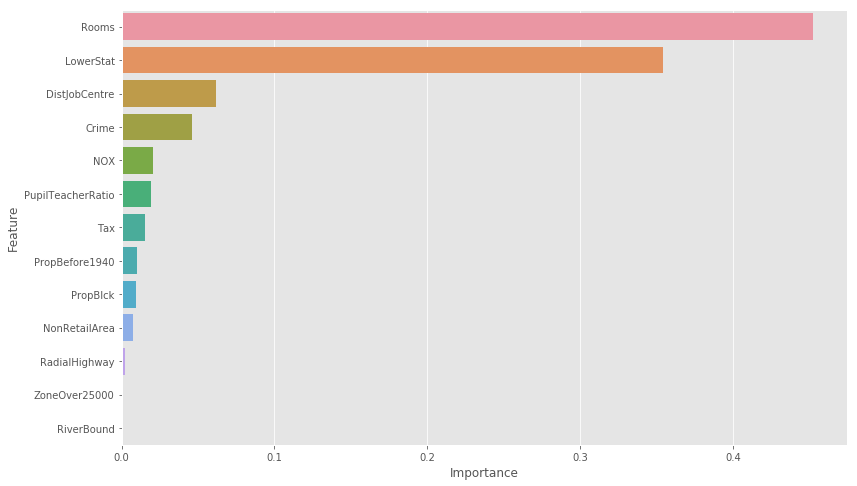

In [185]:
result = try_models(
        features_data=to_try_list[0],
        target_data=df[target],
        rf_params=rf_params,
        num_folds=5,
        random_state=32,
        verbose=False,
        title=titles_list[0]
    )

gs_cv_obj = result[0]

best_forest = gs_cv_obj.best_estimator_
#best_forest.feature_importances_

df_featureimportance = pd.DataFrame(
    data =list(zip(df[features].columns,best_forest.feature_importances_)), 
    columns=["Feature","Importance"])

df_featureimportance.sort_values("Importance",ascending=False,inplace=True)

sns.barplot(y=df_featureimportance.Feature,x=df_featureimportance.Importance)